# MNIST Digit Classification
Author: Gorachand Mondal
<br>GitHub: https://github.com/Gorachand2501

In [8]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [9]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Load and Transform MNIST Data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


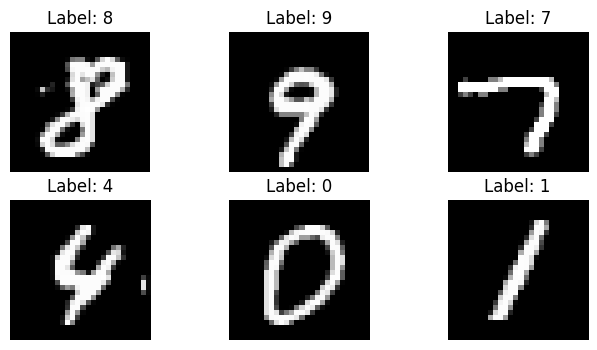

In [11]:
# Visualize Sample Data
def show_sample():
    images, labels = next(iter(train_loader))
    plt.figure(figsize=(8, 4))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

show_sample()

In [12]:
# Define Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = Net().to(device)


In [13]:
# Set Up Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training Loop
def train(model, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

train(model)

Epoch 1, Loss: 253.8955
Epoch 2, Loss: 106.1953
Epoch 3, Loss: 74.3649
Epoch 4, Loss: 58.8459
Epoch 5, Loss: 45.5224


In [15]:
# Evaluation and Accuracy
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds

labels, preds = evaluate(model)

Test Accuracy: 97.69%


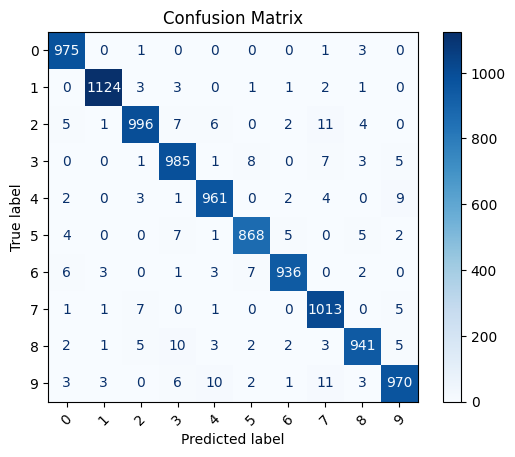

In [16]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Save the Trained Model
torch.save(model.state_dict(), "mnist_model.pth")
print("Model saved as mnist_model.pth")

Model saved as mnist_model.pth
